Sentiment Analysis using Natural Language Processing

Importing all the libraries

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer #Data transformation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import re #Regular Expression

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Importing file contents

file_path_training = r"/content/twitter_training.csv"
file_path_validation = r"/content/twitter_validation.csv"

train_data = pd.read_csv(file_path_training)
val_data = pd.read_csv(file_path_validation)

Data Information and Cleaning

In [ ]:
#First five rows of the training dataset

train_data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
#First five rows of the validation dataset

val_data.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [ ]:
train_data.columns=['id','Entities','Sentiment','Text']
val_data.columns=['id','Entities','Sentiment','Text']

In [ ]:
#With the output of this cell, we see that the headers are inserted properly

train_data.head()

,id,Entities,Sentiment,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
#Finding the shape of the training and validation dataset

print(f'Training Data: {train_data.shape[0]} rows and {train_data.shape[1]} columns')
print(f'Validation Data: {val_data.shape[0]} rows and {val_data.shape[1]} columns')

Training Data: 74681 rows and 4 columns
Validation Data: 999 rows and 4 columns


In [ ]:
#Finding the number of null values in the training data

train_data.isna().sum()

,0
id,0
Entities,0
Sentiment,0
Text,686


In [ ]:
#Finding the number of null values in the validation data

val_data.isna().sum()

,0
id,0
Entities,0
Sentiment,0
Text,0



There are no null values in the validation data.

But there are some present in the training data. As the number of rows with null values are much lesser than the total number of values, we can safely remove the null values

In [ ]:

train_data.dropna(inplace=True)

#Check the number of null values now - should be equal to zero
train_data.isna().sum()

,0
id,0
Entities,0
Sentiment,0
Text,0


Now we will check for duplicate rows in the dataset

In [ ]:
print("Number of duplicate rows in the training dataset -",train_data.duplicated().sum())
print("Number of duplicate rows in the validation dataset -",val_data.duplicated().sum())

Number of duplicate rows in the training dataset - 2340
Number of duplicate rows in the validation dataset - 0


There are no duplicate rows in the validation dataset.

But the duplicate rows in the training data would add no value to our prediction models.

So we will remove the duplicate rows from the training dataset

In [ ]:

train_data.drop_duplicates(inplace=True)

HTML Tags and URLs do not convey any sentiments in the tweets.

So we will remove all the URLs and the HTML Tags present in the dataset

In [ ]:

# Function to remove URLs from text
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Apply the functions to the 'text' column in train_data
train_data['Text'] = train_data['Text'].apply(remove_urls)
train_data['Text'] = train_data['Text'].apply(remove_html_tags)

val_data['Text'] = val_data['Text'].apply(remove_urls)
val_data['Text'] = val_data['Text'].apply(remove_html_tags)

<ipython-input-24-25f7abbdfcf8>:7: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
train_data['text_length'] = [len(t.split()) for t in train_data['Text'].values]

Exploratory Data Analysis

In [ ]:

#We will find the different types of tweets in our dataset.
unique_types = train_data["Sentiment"].unique()
print("Different Types of Sentiments are -",unique_types)

Different Types of Sentiments are - ['Positive' 'Neutral' 'Negative' 'Irrelevant']


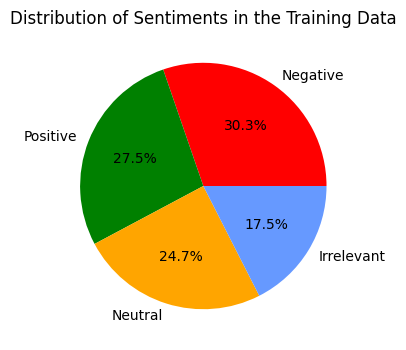

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each type
type_counts_train = train_data['Sentiment'].value_counts()

# Define colors for each sentiment label
label_colors = {
    'Positive': 'green',
    'Negative': 'red',
    'Neutral': 'orange',
    'Irrelevant': (0.4, 0.6, 1.0)
}

# Get the colors corresponding to each label
colors = [label_colors[label] for label in type_counts_train.index]

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(type_counts_train, labels=type_counts_train.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Sentiments in the Training Data')
plt.show()

We notice that the traget classes are almost equal in size. So no resampling is required.

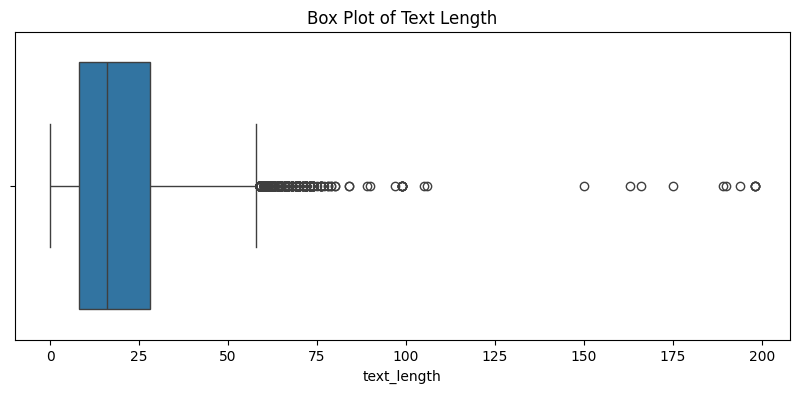

Mean of the length of tweets in the training dataset is 19.505533458935176


In [ ]:
# Create a boxplot for finding the mean and outliers of the length of text
fig, ax = plt.subplots(figsize=(10, 4))

sns.boxplot(data=train_data, x='text_length', ax=ax)
ax.set_title("Box Plot of Text Length")
plt.show()

#Finding the mean of the text length in the dataset
text_length_mean = train_data['text_length'].mean()
print(f"Mean of the length of tweets in the training dataset is {text_length_mean}")


Mean length of tweets is nearly 19.5 tokens. The distribution is scewed positively and a few outliers are observed on the right tail. Some of them are close to the right whisker but some are located far from the majority of points. We will investigate these outliers during text analysis.

For every Sentiment in the given data, there are some words quite often used. For example, the words "love", "like" are more probable to be used in a "Positive" sentiment scenario.

We will now analyse the top words for the all the sentiments.

For this, we will ignore all the stop words. Some of the stop words used in English are given in the output of the cell below

In [ ]:
# First ten Stopwords in the english language - Stopwords are excluded from the text analysis
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

# top words

In [ ]:

import re
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

word_counts = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

pattern = re.compile('[^\w ]')
for text, t in zip(train_data['Text'], train_data['Sentiment']):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)

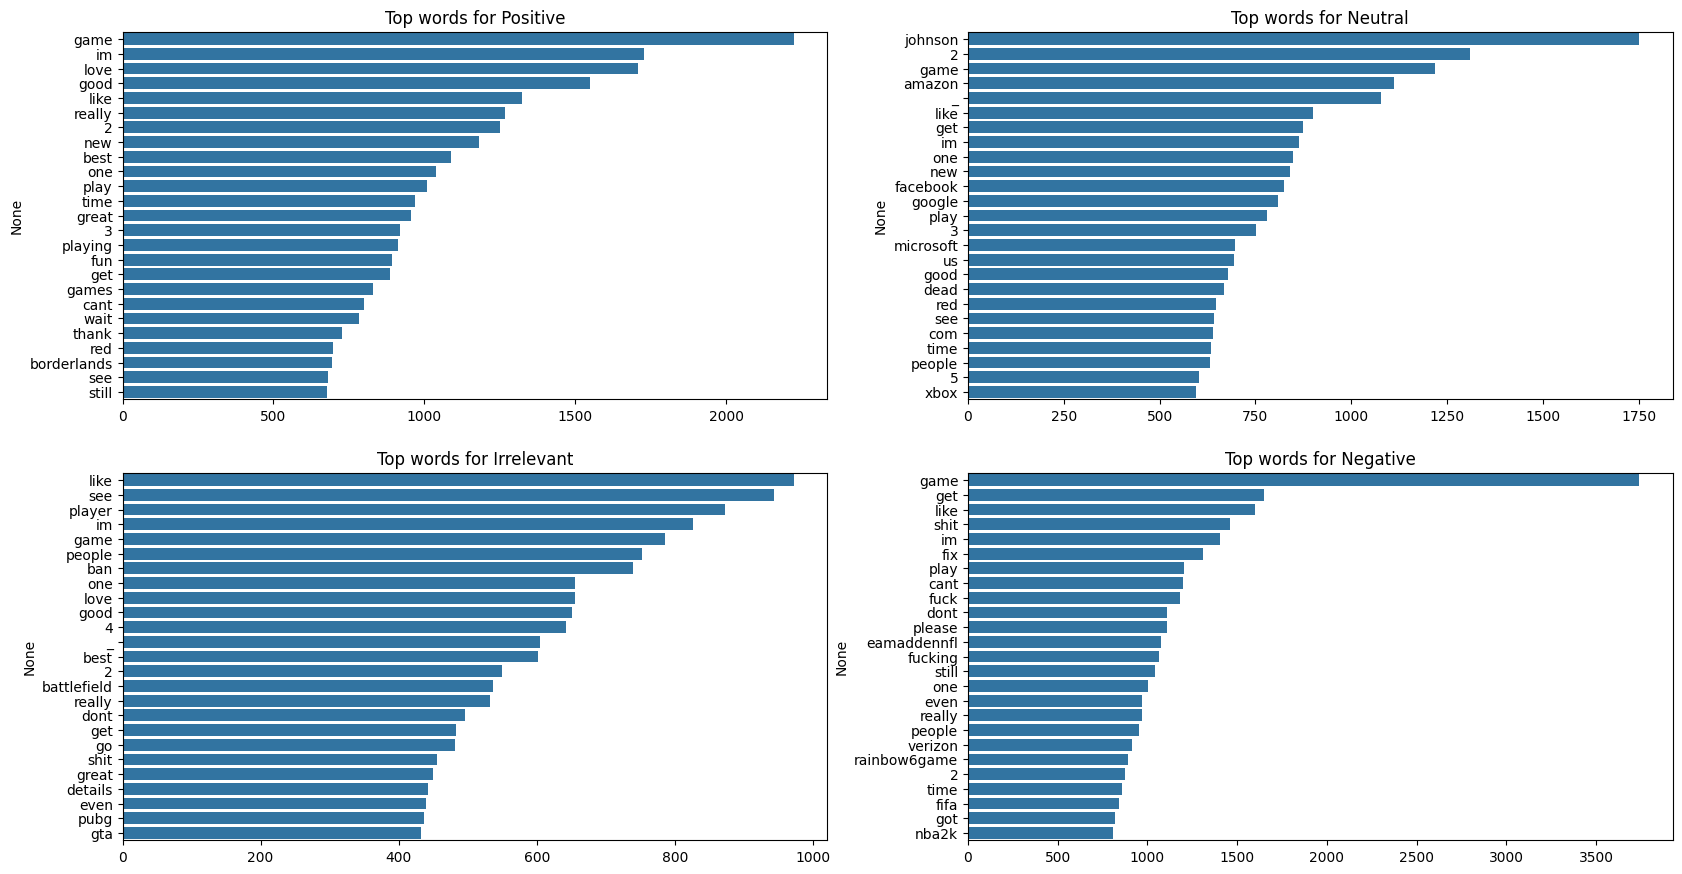

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

In [ ]:
#We will find the different Entities that are present in our dataset.
unique_types = train_data["Entities"].unique()
print(unique_types)

['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']


In [ ]:
#For a particular entity, we will calculate the number of tweets of different sentiments

#Count information per category
plot1_data=train_data.groupby(by=["Entities","Sentiment"]).count().reset_index()

# Remove 'id' and 'lower' columns
plot1_data = plot1_data.drop(columns=['id','text_length'])

# Rename 'text' column to 'count'
plot1_data = plot1_data.rename(columns={'Text': 'count'})

plot1_data.head(4)

,Entities,Sentiment,count
0,Amazon,Irrelevant,185
1,Amazon,Negative,565
2,Amazon,Neutral,1197
3,Amazon,Positive,302


Now we find out which company / video game has the highest number of "Positive" sentiment tweets attached to it

In [ ]:
# Filter rows where the 'Sentiment' column has the value 'positive'
positive_rows = plot1_data[plot1_data['Sentiment'] == 'Positive']

# Find the maximum count and the corresponding row for the filtered rows
max_count_positive = positive_rows['count'].max()
row_with_max_count = positive_rows[positive_rows['count'] == max_count_positive]

# Drop the 'type' column and display the values of the row with the maximum count for positive rows
row_values_max_count = row_with_max_count.drop('Sentiment', axis=1).values.flatten()
print("Row with maximum count for 'positive' rows:")
print(row_values_max_count)

Row with maximum count for 'positive' rows:
['AssassinsCreed' 1382]


We do the same for the company / video game that has the most negative tweets


In [ ]:
# Filter rows where the 'type' column has the value 'negative'
negative_rows = plot1_data[plot1_data['Sentiment'] == 'Negative']

# Find the maximum count and the corresponding row for the filtered rows
max_count_negative = negative_rows['count'].max()
row_with_max_count_negative = negative_rows[negative_rows['count'] == max_count_negative]

# Drop the 'type' column and display the values of the row with the maximum count for negative rows
row_values_max_count_negative = row_with_max_count_negative.drop('Sentiment', axis=1).values.flatten()
print("Row with maximum count for 'negative' rows (values only):")
print(row_values_max_count_negative)

Row with maximum count for 'negative' rows (values only):
['MaddenNFL' 1665]


In the cell below, we will analyse the types of tweets for some of the brands in the dataset

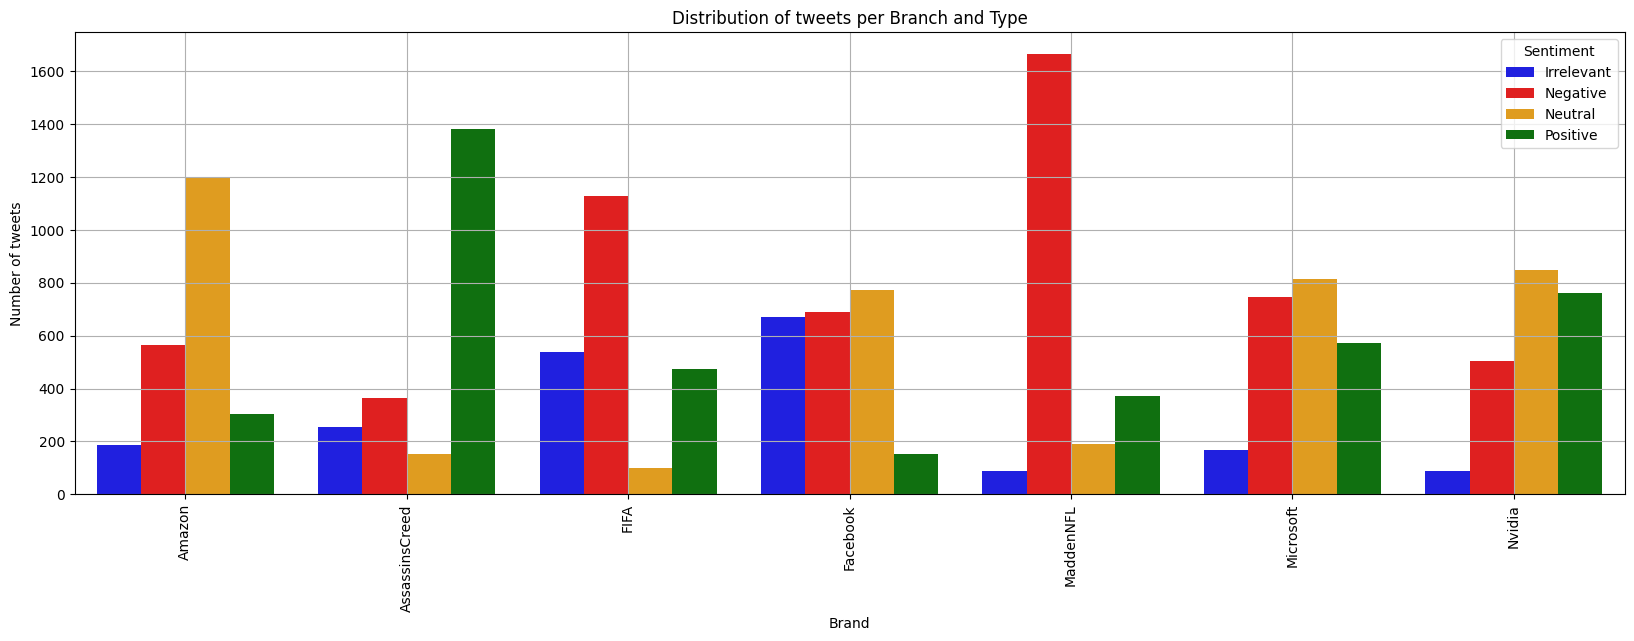

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom color palette
custom_palette = {"Irrelevant": "blue", "Positive": "green", "Neutral": "orange" , "Negative": "red"}

# Filter the data to include only a subset of brands
brands_to_display = ['Amazon', 'AssassinsCreed', 'FIFA' , 'Facebook' , 'Microsoft' , 'Nvidia' , 'MaddenNFL']  # We can add othre brands as well

filtered_data = plot1_data[plot1_data['Entities'].isin(brands_to_display)]

# Use the filtered data in the barplot
plt.figure(figsize=(20, 6))
sns.barplot(data=filtered_data, x="Entities", y="count", hue="Sentiment", palette=custom_palette)
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")

# Show the plot
plt.show()

Text Analysis and Processing


We saw the outliers (in terms of text length) that were present in our dataset.

We will now analyse them and see their contents in the next cell

In [ ]:
#Setting the maximum width of the output screen so as to avoid scrolling
from IPython.display import display, HTML

# Set the maximum width of the output cell and enable text wrapping
display(HTML("<style>.output { max-width:100% !important; }</style>"
             "<style>pre { white-space: pre-wrap; }</style>"))

#With this code, we are seeing the extreme outliers in our dataset which have a text length of more than 125 tokens.
extreme_outliers = train_data['Text'][np.array(train_data['text_length']) > 125]

for idx in extreme_outliers.index:
    print(idx, 'Target: ', train_data['Sentiment'][idx])
    print(extreme_outliers[idx])

    # To put spaces between the tweets
    print("\n\n")

1825 Target:  Neutral
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _



8545 Target:  Positive
I REALLY HAVE THE OVERWATCH RN GAME. SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEE E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E



10453 Target:  Positive
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


Tweets like "######..." have become Nagative labeled. Some of these tweets do not contain any textual information. Such precendents could be removed. Some have both meaningful part and plenty of punctuation characters. They could be removed on the preprocessing stage

Text with very huge number of tokens can also adversely affect our ML model. So we will remove the rows which have the corresponding text above above a certain threshold.

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#remove outliers
train_df = remove_outlier(train_data,'text_length')


Now we will create another box plot tot analyse the text length distribution

As we will observe in the output of the cell below, there are a lot less outliers

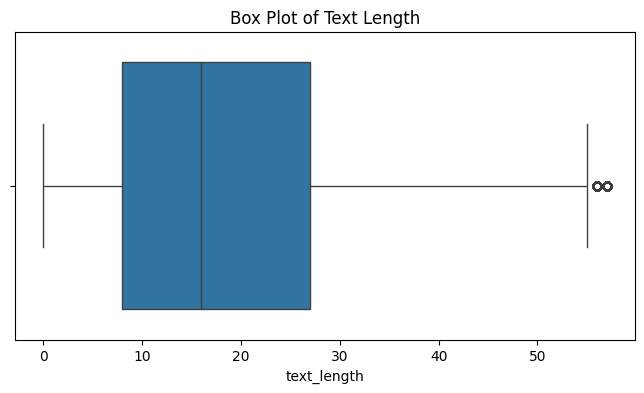

In [ ]:

# Create a boxplot for finding the mean and outliers of the length of text
fig, ax = plt.subplots(figsize=(8, 4))

sns.boxplot(data=train_df, x='text_length', ax=ax)
ax.set_title("Box Plot of Text Length")
plt.show()

In [ ]:
def preprocess_text(text):

    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Joining the words back into a string
    final_text = ' '.join(tokens)
    return final_text

# Preprocess the train_df DataFrame
train_df['Text'] = train_df['Text'].apply(preprocess_text)
val_data['Text'] = val_data['Text'].apply(preprocess_text)

<ipython-input-40-e4485bafe3e3>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Text'] = train_df['Text'].apply(preprocess_text)


In [ ]:
X = train_data['Text']
y = train_data['Sentiment']

# Vectorize the preprocessed text using CountVectorizer
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

Machine Learning Model - Random Forest Classifier

In [ ]:
# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

#Prediction
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print('\nAccuracy (Random Forest):', accuracy_rf)
print('Classification Report (Random Forest):')
print(classification_report(y_test, y_pred_rf))


Accuracy (Random Forest): 0.9223361942641826
Classification Report (Random Forest):
              precision    recall  f1-score   support

  Irrelevant       0.97      0.86      0.92      2455
    Negative       0.92      0.95      0.93      4433
     Neutral       0.91      0.92      0.92      3532
    Positive       0.91      0.93      0.92      3911

    accuracy                           0.92     14331
   macro avg       0.93      0.92      0.92     14331
weighted avg       0.92      0.92      0.92     14331




Final Results using Validation Data

In [ ]:
X = train_data['Text']
y = train_data['Sentiment']

# Vectorize the preprocessed text using CountVectorizer
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Predict using the trained Random Forest classifier
y_pred_val = rf_classifier.predict(X_vectorized)

# Calculate accuracy on the validation dataset
accuracy_val = accuracy_score(y, y_pred_val)
print('\nAccuracy on Validation Dataset:', accuracy_val)

# Calculate the classification report
classification_report_val = classification_report(y, y_pred_val)

# Print the classification report
print('Classification Report on Validation Dataset:')
print(classification_report_val)


Accuracy on Validation Dataset: 0.9680971320912707
Classification Report on Validation Dataset:
              precision    recall  f1-score   support

  Irrelevant       0.99      0.95      0.97     12537
    Negative       0.97      0.97      0.97     21698
     Neutral       0.94      0.98      0.96     17708
    Positive       0.97      0.97      0.97     19712

    accuracy                           0.97     71655
   macro avg       0.97      0.97      0.97     71655
weighted avg       0.97      0.97      0.97     71655

